# 1. Install depedencies

This notebook is an **improved version** of the previous data preprocessing and augmentation notebook.  

It addresses issues identified in the earlier version, including:  
- Incorrectly applied mathematical formulas  
- Potential data leakage  
- Errors in calculations or preprocessing steps  

This version is designed to provide more accurate and reliable preprocessing, while still allowing comparisons with the original notebook.  

At the end of each notebook name, you will find a **`_vX` versioning** label, such as `_v2` here, where a higher number indicates a more refined and improved version.

In [1]:
!python --version

Python 3.9.23


In [2]:
!python -c "import torch; import torchvision; import sys;print('\nIgnore output above, BELOW ARE VERSION LISTED:\n');print('Python version:',sys.version);print('Pytorch version:', torch.__version__); print('Torchvision version:', torchvision.__version__)"

/opt/anaconda3/envs/uzslr-signs/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/uzslr-signs/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/uzslr-signs/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/uzslr-signs/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/uzslr-signs/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/uzslr-signs/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/uzslr-signs/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environ

In [3]:
!conda export --from-history # does not list pip installed packages, so manually have to add to .yml

name: uzslr-signs
channels:
  - conda-forge
  - defaults
  - https://repo.anaconda.com/pkgs/main
  - https://repo.anaconda.com/pkgs/r
dependencies:
  - python=3.9.23
  - ipykernel
  - pytorch=2.5.1
  - torchvision=0.20.1
  - jupyter
  - pandas=2.3.1
  - matplotlib=3.9.4
  - numpy=2.0.2
  - scikit-learn=1.6.1
  - tqdm=4.67.1
  - opencv
  - pathlib=1.0.1
prefix: /opt/anaconda3/envs/uzslr-signs


In [4]:
!which pip

/opt/anaconda3/envs/uzslr-signs/bin/pip


In [5]:
!which pip3

/opt/anaconda3/envs/uzslr-signs/bin/pip3


In [6]:
#!conda install pytorch=2.5.1 torchvision=0.20.1 torchaudio -c pytorch

In [7]:
#!pip3/conda uninstall torch torchvision torchaudio -y # delete pytorch

In [8]:
!conda install -q --yes jupyter=1.1.1 ipykernel=6.30.1 # although downloaded from terminal, leaving here for exact versioning

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: ...working... done

# All requested packages already installed.



In [9]:
!conda install -q --yes numpy=2.0.2 pandas=2.3.1 matplotlib=3.9.4 scikit-learn=1.6.1 tqdm=4.67.1 pathlib=1.0.1

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: ...working... done

# All requested packages already installed.



In [10]:
!conda install -q --yes -c conda-forge opencv=4.12.0

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: ...working... done

# All requested packages already installed.



# 2. Config

In [1]:
# checking if mps is enabled. MPS is Apple Sillion GPU
!python -c "import torch; print(f'MPS available: {torch.backends.mps.is_available()}'); print(f'MPS built with PyTorch: {torch.backends.mps.is_built()}')"


MPS available: True
MPS built with PyTorch: True


In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.autonotebook import tqdm
import sklearn

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import glob
import datetime
from pathlib import Path
import PIL
from IPython.display import Image

print(f'PyTorch Version: {torch.__version__}')
print(f'Python Version: {sys.version}')

PyTorch Version: 2.5.1
Python Version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 18:02:02) 
[Clang 18.1.8 ]


# 3. Work

In [4]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        device_name = "Apple MPS"
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = "CUDA GPU"
    else:
        device = torch.device("cpu")
        device_name = "CPU"

    print(f"Using device: {device_name}")
    return device

In [5]:
seed_everything(42)
device = get_device()
N_REPLICAS = 1

Using device: Apple MPS


## 3.1 loading dataset

### Dataset Structure
<pre>
.
└── data/
    ├── train/
    │   └── {sign}/                  # e.g., assalomu_alaykum, bahor, ...
    │        └── rep-{XX}/           # e.g., rep-0, rep-01, ..., rep-XX (repetitions)
    │            ├── frame-00.npy
    │            ├── ...
    │            └── frame-XX.npy
    │
    ├── validation/         # used for hyperparameter tunning
    │   └── {sign}/
    │        └── rep-{XX}/        
    │            ├── frame-00.npy
    │            ├── ...
    │            └── frame-XX.npy
    │
    └── test/               # used for the final model results
        └── {sign}/
             └── rep-{XX}/       
                 ├── frame-00.npy
                 ├── ...
                 └── frame-XX.npy

</pre>

In [6]:
DATA_ROOT = Path("../../data")
SPLITS = ["train", "validation", "test"]

# 50 signs
DEFAULT_SIGNS = ['assalomu_alaykum', 'bahor', 'birga', "bo'sh", 'bosh_kiyim', 'boshlanishi', 'bozor', 'eshik', 
               'futbol', 'iltimos', 'internet', 'javob', 'jismoniy_tarbiya', 'karam', 'kartoshka', 
               'kichik', 'kitob', "ko'prik", 'likopcha', 'maktab', 'mehmonxona', 'mehribon', 'metro', 
               'musiqa', "o'simlik_yog'i", "o'ynash", 'ochish', 'ot', 'ovqat_tayyorlash', 
               'oxiri', 'poezd', 'pomidor', 'qidirish', 'qish', "qo'ziqorin", 'qor', "qorong'i", 'quyon', 
               'restoran', "sariyog'", 'shokolad', 'sovun', 'stakan', 'televizor', 'tosh', 'toza',
               'turish', "yomg'ir", 'yopish', 'yordam_berish'] 

In [7]:
label2id = {sign: idx for idx, sign in enumerate(DEFAULT_SIGNS)}
id2label = {idx: sign for sign, idx in label2id.items()}

NUM_CLASSES = len(DEFAULT_SIGNS)
print("Number of classes:", NUM_CLASSES)

Number of classes: 50


In [8]:
label2id # sign: id

{'assalomu_alaykum': 0,
 'bahor': 1,
 'birga': 2,
 "bo'sh": 3,
 'bosh_kiyim': 4,
 'boshlanishi': 5,
 'bozor': 6,
 'eshik': 7,
 'futbol': 8,
 'iltimos': 9,
 'internet': 10,
 'javob': 11,
 'jismoniy_tarbiya': 12,
 'karam': 13,
 'kartoshka': 14,
 'kichik': 15,
 'kitob': 16,
 "ko'prik": 17,
 'likopcha': 18,
 'maktab': 19,
 'mehmonxona': 20,
 'mehribon': 21,
 'metro': 22,
 'musiqa': 23,
 "o'simlik_yog'i": 24,
 "o'ynash": 25,
 'ochish': 26,
 'ot': 27,
 'ovqat_tayyorlash': 28,
 'oxiri': 29,
 'poezd': 30,
 'pomidor': 31,
 'qidirish': 32,
 'qish': 33,
 "qo'ziqorin": 34,
 'qor': 35,
 "qorong'i": 36,
 'quyon': 37,
 'restoran': 38,
 "sariyog'": 39,
 'shokolad': 40,
 'sovun': 41,
 'stakan': 42,
 'televizor': 43,
 'tosh': 44,
 'toza': 45,
 'turish': 46,
 "yomg'ir": 47,
 'yopish': 48,
 'yordam_berish': 49}

In [9]:
id2label # id: sign

{0: 'assalomu_alaykum',
 1: 'bahor',
 2: 'birga',
 3: "bo'sh",
 4: 'bosh_kiyim',
 5: 'boshlanishi',
 6: 'bozor',
 7: 'eshik',
 8: 'futbol',
 9: 'iltimos',
 10: 'internet',
 11: 'javob',
 12: 'jismoniy_tarbiya',
 13: 'karam',
 14: 'kartoshka',
 15: 'kichik',
 16: 'kitob',
 17: "ko'prik",
 18: 'likopcha',
 19: 'maktab',
 20: 'mehmonxona',
 21: 'mehribon',
 22: 'metro',
 23: 'musiqa',
 24: "o'simlik_yog'i",
 25: "o'ynash",
 26: 'ochish',
 27: 'ot',
 28: 'ovqat_tayyorlash',
 29: 'oxiri',
 30: 'poezd',
 31: 'pomidor',
 32: 'qidirish',
 33: 'qish',
 34: "qo'ziqorin",
 35: 'qor',
 36: "qorong'i",
 37: 'quyon',
 38: 'restoran',
 39: "sariyog'",
 40: 'shokolad',
 41: 'sovun',
 42: 'stakan',
 43: 'televizor',
 44: 'tosh',
 45: 'toza',
 46: 'turish',
 47: "yomg'ir",
 48: 'yopish',
 49: 'yordam_berish'}

In [10]:
def build_index(split):
    split_path = DATA_ROOT / split
    samples = []

    for sign in DEFAULT_SIGNS:
        sign_path = split_path / sign
        if not sign_path.exists():
            continue

        label = label2id[sign]

        for rep_dir in sign_path.iterdir():
            if not rep_dir.is_dir():
                continue

            frames = sorted(rep_dir.glob("frame-*.npy"))
            if len(frames) != 32:
                continue  # safety

            samples.append({
                "frames": frames,
                "label": label,
                "sign": sign,
                "rep_path": rep_dir
            })

    return samples

<details>
<summary>Template for loading <code>.npy</code> using <code>Dataset</code> class and <code>build_index(split)</code> function.</summary>

## `Dataset` class usage template

```python
class SignDataset(Dataset):
    def __init__(self, split, preprocess, augment=False): 
        # preprocess and augment are the instances of the class, will be in the next steps
        self.samples = build_index(split)
        self.preprocess = preprocess
        self.augment = augment

    def __getitem__(self, idx):
        sample = self.samples[idx]
        frames = [np.load(p) for p in sample["frames"]]
        frames = torch.tensor(frames, dtype=torch.float32)  # MPS as of now, cannot handle float64

        if self.augment:
            frames = augment(frames)
        
        x = self.preprocess(frames)
        y = sample["label"]
        return x, y

    def __len__(self):
        return len(self.samples)
```

</details>

In [11]:
train_samples = build_index("train")
val_samples   = build_index("validation")
test_samples  = build_index("test")

print("Train samples:", len(train_samples))
print("Val samples:", len(val_samples))
print("Test samples:", len(test_samples))

Train samples: 2038
Val samples: 250
Test samples: 300


## 3.2 preprocess

In [12]:
FACE_LANDMARKS = 468
POSE_LANDMARKS = 33
HAND_LANDMARKS = 21

In [13]:
FACE_START = 0
FACE_END   = 468 * 3

POSE_START = FACE_END
POSE_END   = POSE_START + 33 * 4

RH_START   = POSE_END
RH_END     = RH_START + 21 * 3

LH_START   = RH_END
LH_END     = LH_START + 21 * 3

In [14]:
MAX_LEN = 32              # fixed
PAD_VALUE = 0.0           # shorter frames are not padded
NUM_CLASSES = 50          # 50 uzbek signs

In [15]:
NOSE=[
    1,2,98,327
]
# additional info
LNOSE = [98]
RNOSE = [327]

LIP = [ 0, 
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

# additional info
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

# as of now testing without a pose
POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

RHAND = list(range(468 + 33, 468 + 33 + 21))      # [501, 502, ..., 522] 
LHAND = list(range(468 + 33 + 21, 468 + 33 + 42)) # [522, 523, ..., 542]


POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE 

NUM_NODES = len(POINT_LANDMARKS)  # 118 selected features
CHANNELS = 6 * NUM_NODES          # 708 total output features

# 6 is chosen because (2 channels -> (x, y) × 3 -> position, first difference:velocity, second difference:acceleration) = (2*3) = 6
# out of (x,y,z) and visibility, only (x,y) values are chosen as feature inputs
print(NUM_NODES, CHANNELS)

118 708


In [16]:
print(f"NOSE: {len(NOSE)}")
print(f"  LNOSE: {len(LNOSE)}")
print(f"  RNOSE: {len(RNOSE)}\n")

print(f"LIP: {len(LIP)}")
print(f"  LLIP: {len(LLIP)}")
print(f"  RLIP: {len(RLIP)}\n")

print(f"POSE: {len(POSE)}")
print(f"  LPOSE: {len(LPOSE)}")
print(f"  RPOSE: {len(RPOSE)}\n")

print(f"REYE: {len(REYE)}")
print(f"LEYE: {len(LEYE)}\n")

print(f"RHAND: {len(RHAND)}")
print(f"LHAND: {len(LHAND)}\n")

print(f"POINT_LANDMARKS: {len(POINT_LANDMARKS)}")

NOSE: 4
  LNOSE: 1
  RNOSE: 1

LIP: 40
  LLIP: 18
  RLIP: 18

POSE: 8
  LPOSE: 4
  RPOSE: 4

REYE: 16
LEYE: 16

RHAND: 21
LHAND: 21

POINT_LANDMARKS: 118


In [17]:
"""
B = number of sign samples in batch
T = number of frames (32)
N = number of landmarks used (118)
C = features per landmark (x,y + motion)

(B, T, N × C)
"""

'\nB = number of sign samples in batch\nT = number of frames (32)\nN = number of landmarks used (118)\nC = features per landmark (x,y + motion)\n\n(B, T, N × C)\n'

In [18]:
# Convert (1662,) numpy ndarray -> (543,3) torch tensor
def unpack_frame(vec):
    """
    vec: (1662,)
    returns: (543, 3)
    """
    vec = torch.tensor(vec, dtype=torch.float32)
    
    face = vec[0:468*3].reshape(468, 3)

    pose = vec[468*3 : 468*3 + 33*4].reshape(33, 4)
    pose = pose[:, :3]  # drop visibility

    rh = vec[468*3 + 33*4 : 468*3 + 33*4 + 21*3].reshape(21, 3)
    lh = vec[468*3 + 33*4 + 21*3 :].reshape(21, 3)

    return torch.cat([face, pose, rh, lh], dim=0) # (543, 3)

In [19]:
class Preprocess(nn.Module):
    def __init__(self, max_len=32, point_landmarks=POINT_LANDMARKS):
        super().__init__()
        self.max_len = max_len
        self.register_buffer(
            "landmark_idx",
            torch.tensor(point_landmarks, dtype=torch.long)
        )

    def forward(self, x):
        """
        x: (1662,) single frame or, 
           (T, 1662) stacked frames or,
           (T, 543, 3) only if augmentation is applied, which unpacks 
        returns: (T, 6 * NUM_NODES)
        """
        
        """
        # as a sanity check, but not considered right now
        if isinstance(vec, np.ndarray):
            vec = torch.from_numpy(vec).to(torch.float32)
        else:
            vec = vec.to(torch.float32)
        """
            
        # automatically unpack if needed
        if x.dim() == 1 and x.shape[0] == 1662:
            # single frame (1662,)
            frames = unpack_frame(x).unsqueeze(0)  # (1, 543, 3)
        elif x.dim() == 2 and x.shape[1] == 1662:
            # stacked frames (T, 1662)
            # vectorized unpacking, should be much faster than calling unpack_frame 32 times for each repetition
            x = x.to(torch.float32)
            
            face = x[:, 0:468*3].reshape(-1, 468, 3)
            pose = x[:, 468*3 : 468*3 + 33*4].reshape(-1, 33, 4)[:, :, :3] # drop visibility
            rh = x[:, 468*3 + 33*4 : 468*3 + 33*4 + 21*3].reshape(-1, 21, 3)
            lh = x[:, 468*3 + 33*4 + 21*3 :].reshape(-1, 21, 3)
            
            frames = torch.cat([face, pose, rh, lh], dim=1)  # (T, 543, 3)
        elif x.dim() == 3 and x.shape[1:] == (543, 3):
            # already unpacked (T, 543, 3)
            frames = x
        else:
            raise ValueError(f"Unexpected input shape {x.shape}")

        
        # gather only selected 118 landmarks
        frames = frames[:, self.landmark_idx]  # (T, N, 3)

        # use only x,y columns
        frames = frames[..., :2]  # (T, N, 2)

        assert 17 in POINT_LANDMARKS, "Center landmark 17 missing" # helps to spot missing 17th landmark error
        
        # center using landmark 17 (nose reference)
        # here the center normalization is global over time (one single center for the entire sequence), as per code of Sohn. H (2023)
        # however, experimenting with center normalization per-frame and not over entire sequence could be tried out
        # if per-frame approach is tried out, then comment out these below 3 lines of center related code
        center = frames[:, self.landmark_idx.tolist().index(17):self.landmark_idx.tolist().index(17)+1]
        center = torch.nanmean(center, dim=(0,1), keepdim=True)
        center = torch.where(torch.isnan(center), torch.tensor(0.5, dtype=center.dtype, device=center.device), center)
        
        """
        # comment above 3 lines of "center" code, and uncomment the below 4 lines "center" code if it is being exprimented
        # may be experimented in the future
        # per-frame center normalization
        center_idx = self.landmark_idx.tolist().index(17)
        center = frames[:, center_idx:center_idx+1]       # (T,1,2)
        center = torch.nanmean(center, dim=1, keepdim=True)  # mean per frame
        center = torch.nan_to_num(center, nan=0.5)
        """
        
        # normalize relative to center
        diff = frames - center
        diff = torch.where(torch.isnan(diff), torch.zeros_like(diff), diff)  # replace NaN with 0
        std = torch.std(diff, dim=(0, 1), keepdim=True, unbiased=False)  #fixed standard deviation
        std = torch.clamp(std, min=1e-6)
        
        frames = diff / std

        # capturing temporal dynamics
        # velocity
        dx = torch.zeros_like(frames)
        dx[1:] = frames[1:] - frames[:-1]

        # acceleration
        dx2 = torch.zeros_like(frames)
        dx2[2:] = frames[2:] - 2*frames[1:-1] + frames[:-2] # fixed: now it is true second derivative, and does not depend on dx value
        """
        dx2[2:] = dx[2:] - dx[1:-1] also provides acceleration, but the value is dependent on first derivate
        if any changes happen to dx, so is dx2 effected by it.

        initially, it was not even acceleration, this code used to be: dx2[2:] = frames[2:] - frames[:-2] 
        which is 2nd-order/step difference and NOT the acceleration
        """

        # flatten per frame
        frames = frames.reshape(frames.shape[0], -1) 
        dx     = dx.reshape(dx.shape[0], -1)
        dx2    = dx2.reshape(dx2.shape[0], -1)

        return torch.cat([frames, dx, dx2], dim=-1) # (T, 708)

### 3.2.1 testing

In [20]:
preprocessor = Preprocess(max_len=32) 

# Load a single frame
frame_path = "/Users/macbookair/Downloads/frame-00.npy"
frame = np.load(frame_path)  # Input shape: (1662,)

# Convert to torch tensor and add batch dimension
frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)  # shape: (1, 1662)

# Process it
features = preprocessor(frame_tensor)  # Output shape: (1, 708)
print("Single frame processed:", features.shape, features.device)

Single frame processed: torch.Size([1, 708]) cpu


In [21]:
frame_path

'/Users/macbookair/Downloads/frame-00.npy'

In [22]:
frame_tensor.shape

torch.Size([1, 1662])

In [23]:
# Folder containing .npy frames
folder_path = "/Users/macbookair/Downloads/rep-1"

# List all .npy files in the folder, sorted by name
frame_paths = sorted([os.path.join(folder_path, f) 
                      for f in os.listdir(folder_path) if f.endswith(".npy")])

# Load all frames
frames = [np.load(p) for p in frame_paths]

# Stack into a single array: shape (T, 1662), should be (32, 1662) for a single repetition
frames_tensor = torch.tensor(np.stack(frames), dtype=torch.float32)

# Initialize preprocessor
preprocessor = Preprocess(max_len=32)

# Process sequence: output shape (T, 708)
features_seq = preprocessor(frames_tensor)

print("Sequence processed:", features_seq.shape, features_seq.device)

Sequence processed: torch.Size([32, 708]) cpu


In [24]:
frame_paths

['/Users/macbookair/Downloads/rep-1/frame-00.npy',
 '/Users/macbookair/Downloads/rep-1/frame-01.npy',
 '/Users/macbookair/Downloads/rep-1/frame-02.npy',
 '/Users/macbookair/Downloads/rep-1/frame-03.npy',
 '/Users/macbookair/Downloads/rep-1/frame-04.npy',
 '/Users/macbookair/Downloads/rep-1/frame-05.npy',
 '/Users/macbookair/Downloads/rep-1/frame-06.npy',
 '/Users/macbookair/Downloads/rep-1/frame-07.npy',
 '/Users/macbookair/Downloads/rep-1/frame-08.npy',
 '/Users/macbookair/Downloads/rep-1/frame-09.npy',
 '/Users/macbookair/Downloads/rep-1/frame-10.npy',
 '/Users/macbookair/Downloads/rep-1/frame-11.npy',
 '/Users/macbookair/Downloads/rep-1/frame-12.npy',
 '/Users/macbookair/Downloads/rep-1/frame-13.npy',
 '/Users/macbookair/Downloads/rep-1/frame-14.npy',
 '/Users/macbookair/Downloads/rep-1/frame-15.npy',
 '/Users/macbookair/Downloads/rep-1/frame-16.npy',
 '/Users/macbookair/Downloads/rep-1/frame-17.npy',
 '/Users/macbookair/Downloads/rep-1/frame-18.npy',
 '/Users/macbookair/Downloads/r

In [25]:
frames_tensor.shape

torch.Size([32, 1662])

### 3.2.2 visualization of preprocessing

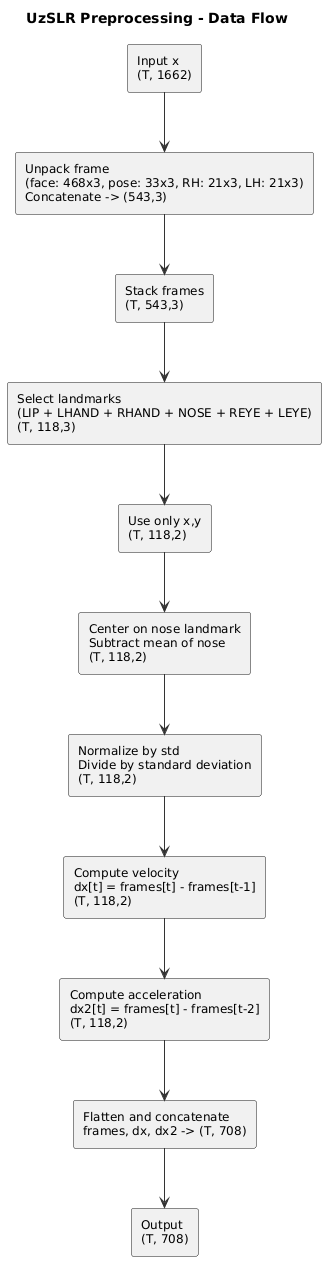

In [26]:
Image(filename='../../docs/images/preprocess_v1_data_flow.png', width=300) # T is number of frames

<details>
<summary><i>To see, preprocessing PlantUML code, click here.</i></summary>

## PlantUML code:
```code
@startuml
title UzSLR Preprocessing - Data Flow

skinparam defaultFontSize 12
skinparam ArrowColor #333
skinparam BoxBorderColor black
skinparam BoxBackgroundColor #EFEFEF

' Input
rectangle "Input x\n(T, 1662)" as Input {
  ' Each frame flattened: 468 face + 33 pose + 21 RH + 21 LH
}

' Unpack each frame
rectangle "Unpack frame\n(face: 468x3, pose: 33x3, RH: 21x3, LH: 21x3)\nConcatenate -> (543,3)" as Unpack {
  ' Drop pose visibility channel
}

' Stack frames
rectangle "Stack frames\n(T, 543,3)" as Stack {
  ' All frames stacked along first dimension
}

' Select relevant landmarks
rectangle "Select landmarks\n(LIP + LHAND + RHAND + NOSE + REYE + LEYE)\n(T, 118,3)" as Landmark {
  ' Gather important points
}

' Use only x,y
rectangle "Use only x,y\n(T, 118,2)" as XY {
  ' Drop z-coordinate
}

' Center on nose
rectangle "Center on nose landmark\nSubtract mean of nose\n(T, 118,2)" as Center {
  ' Nose reference: landmark 17
}

' Normalize
rectangle "Normalize by std\nDivide by standard deviation\n(T, 118,2)" as Normalize {
  ' Avoid division by zero
}

' Compute velocity
rectangle "Compute velocity\ndx[t] = frames[t] - frames[t-1]\n(T, 118,2)" as Velocity {
  ' First frame = 0
}

' Compute acceleration
rectangle "Compute acceleration\ndx2[t] = frames[t] - frames[t-2]\n(T, 118,2)" as Acceleration {
  ' First two frames = 0
}

' Flatten and concatenate
rectangle "Flatten and concatenate\nframes, dx, dx2 -> (T, 708)" as Flatten {
  ' 118 points * 2 coords * 3 (position, velocity, acceleration)
}

' Output
rectangle "Output\n(T, 708)" as Output

' Draw the flow (one arrow per line)
Input --> Unpack
Unpack --> Stack
Stack --> Landmark
Landmark --> XY
XY --> Center
Center --> Normalize
Normalize --> Velocity
Velocity --> Acceleration
Acceleration --> Flatten
Flatten --> Output

@enduml

```

</details>

| Step               | Input Shape    | Output Shape | Notes                               |
| ------------------ | -------------- | ------------ | ----------------------------------- |
| Original frame     | (1662,)        | (543, 3)     | unpack 3D coordinates               |
| Select landmarks   | (543, 3)       | (118, 3)     | Use lips, hands, eyes, nose         |
| Drop Z             | (118, 3)       | (118, 2)     | Only x, y                           |
| Center and normalize | (T, 118, 2)    | (T, 118, 2)  | Relative to nose, std normalization |
| Velocity           | (T, 118, 2)    | (T, 118, 2)  | $d^1x$ between frames                   |
| Acceleration       | (T, 118, 2)    | (T, 118, 2)  | $d^2x$ between frames                  |
| Flatten and concat   | (T, 118, 2) ×3 | (T, 708)     | 6 channels per node(row)               |

T is number of frames

## 3.3 augment

In [27]:
ROWS_PER_FRAME = 543
NUM_CLASSES = 50

SIGN2IDX = {s: i for i, s in enumerate(DEFAULT_SIGNS)}

In [28]:
# horizontal flip
def swap(x, a, b):
    tmp = x[:, a].clone()
    x[:, a] = x[:, b]
    x[:, b] = tmp

def flip_lr(x):
    x = x.clone()
    
    # global center across all frames and landmarks
    center_x = torch.nanmean(x[..., 0])  # Scalar
    
    # mirror around global center
    x[..., 0] = 2 * center_x - x[..., 0]

    swap(x, LHAND, RHAND)
    swap(x, LLIP,  RLIP)
    swap(x, LPOSE, RPOSE)
    swap(x, LEYE,  REYE)
    swap(x, LNOSE, RNOSE)

    return x

In [29]:
# temporal resampling, simulating signs with varying speeds, can increase/decrease number of frames (T)
def resample(x, rate=(0.8, 1.2)):
    t = x.shape[0]
    new_t = int(t * random.uniform(*rate))
    new_t = max(1, new_t)
    idx = torch.round(torch.linspace(0, t - 1, new_t)).long()
    idx = torch.clamp(idx, 0, t - 1)
    return x[idx]

In [30]:
"""
   Helper functions 
"""

'\n   Helper functions \n'

In [31]:
def nanmean(x, dim, keepdim=False):
    """
    Compute mean ignoring NaNs
    x: torch.Tensor
    dim: int or tuple
    """
    mask = ~torch.isnan(x)
    x = torch.where(mask, x, torch.tensor(0., device=x.device, dtype=x.dtype))
    count = mask.sum(dim=dim, keepdim=keepdim).clamp(min=1)
    return x.sum(dim=dim, keepdim=keepdim) / count

def nanmin(x, dim, keepdim=False):
    x_masked = x.clone()
    x_masked[torch.isnan(x_masked)] = float('inf')
    return x_masked.min(dim=dim, keepdim=keepdim).values

def nanmax(x, dim, keepdim=False):
    x_masked = x.clone()
    x_masked[torch.isnan(x_masked)] = float('-inf')
    return x_masked.max(dim=dim, keepdim=keepdim).values

In [32]:
# random affine
def spatial_random_affine(
    x,
    scale=(0.8, 1.2),
    shear=(-0.15, 0.15),
    shift=(-0.1, 0.1),
    degree=(-30, 30),
):
    """
    Works with any coordinate range (no [0,1] assumption)
    
    x: (T, 543, 3)
    """
    x = x.clone()
    
    # global center across all frames
    center = torch.stack([
        torch.nanmean(x[..., 0]),
        torch.nanmean(x[..., 1])
    ]).to(dtype=x.dtype, device=x.device)  # (2,)
    
    # scale
    if scale:
        s = random.uniform(*scale)
        x[..., :2] = (x[..., :2] - center) * s + center
    
    # shear
    if shear:
        sh = random.uniform(*shear)
        mat = torch.tensor([[1, sh], [sh, 1]], device=x.device, dtype=x.dtype)
        x[..., :2] = (x[..., :2] - center) @ mat + center
    
    # rotation
    if degree:
        theta = random.uniform(*degree) * np.pi / 180
        c, s_val = np.cos(theta), np.sin(theta)
        rot = torch.tensor([[c, s_val], [-s_val, c]], device=x.device, dtype=x.dtype)
        x[..., :2] = (x[..., :2] - center) @ rot + center
    

    # shift proportional to global extent (same shift for all frames)
    if shift:
        # global min/max across all frames and landmarks
        coords = x[..., :2].reshape(-1, 2)  # shape (T*543, 2)
        min_xy = nanmin(coords, dim=0)       # shape (2,)
        max_xy = nanmax(coords, dim=0)
        extent = max_xy - min_xy
        delta = random.uniform(*shift) * extent
        x[..., :2] += delta

    return x

In [33]:
# random cutout 
def temporal_crop(x, length=MAX_LEN):
    if x.shape[0] <= length:
        return x
    start = random.randint(0, x.shape[0] - length)
    return x[start:start + length]

def temporal_mask(x, size=(0.2,0.4)): # due to possibility of introducing discountinities, as of now not used
    t = x.shape[0]
    m = int(t * random.uniform(*size))
    m = max(1, m)
    s = random.randint(0, max(0, t - m))
    x = x.clone()
    x[s:s+m] = 0
    return x

In [34]:
def spatial_mask(x, size=(0.2, 0.4)):
    """
    Mask the same rectangular region across all frames (temporally consistent)
    
    x: (T, 543, 3)
    """
    x = x.clone()
    
    # global coordinate bounds across all frames
    coords = x[..., :2].reshape(-1, 2)  # (T*543, 2)
    xmin = nanmin(coords, dim=0)[0]  # Scalar
    xmax = nanmax(coords, dim=0)[0]
    ymin = nanmin(coords, dim=0)[1]
    ymax = nanmax(coords, dim=0)[1]
    
    w = xmax - xmin
    h = ymax - ymin
    
    if w <= 0 or h <= 0:
        return x
    
    m = random.uniform(*size)
    mx = xmin + random.random() * (1 - m) * w
    my = ymin + random.random() * (1 - m) * h
    
    # apply same mask to all frames (vectorized)
    mask = (
        (x[..., 0] > mx) & (x[..., 0] < mx + m * w) &
        (x[..., 1] > my) & (x[..., 1] < my + m * h)
    )  
    
    x[mask] = 0
    
    return x

In [35]:
# Pad shorter sequences and Truncate longer sequences
# Since some of the augmentations can change the number of frames (T), this preprocess helps to have the same number of frames
# even after augmentation
# not used directly here, but left as a reference
def pad_or_truncate(x):
    # x: [T, 543, 3]
    if x.shape[0] < MAX_LEN:
        pad = torch.zeros((MAX_LEN - x.shape[0], x.shape[1], x.shape[2]), dtype=x.dtype, device=x.device)
        x = torch.cat([x, pad], dim=0)
    else:
        x = x[:MAX_LEN]
    return x

In [36]:
# not used, but left here as a reference
def unpack_batch(x):
    """
    x: (T, 1662) numpy or torch
    returns: (T, 543, 3)
    """
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).to(torch.float32)
    else:
        x = x.to(torch.float32)
    
    face = x[:, 0:468*3].reshape(-1, 468, 3)
    pose = x[:, 468*3 : 468*3 + 33*4].reshape(-1, 33, 4)[:, :, :3] # drop visibility
    rh = x[:, 468*3 + 33*4 : 468*3 + 33*4 + 21*3].reshape(-1, 21, 3)
    lh = x[:, 468*3 + 33*4 + 21*3 :].reshape(-1, 21, 3)
    
    return torch.cat([face, pose, rh, lh], dim=1)  # (T, 543, 3)

In [37]:
# augmentations will be applied randomly
def augment_fn(x, always=False):
    """
    x: (T, 1662) or (T, 543, 3)
    returns: (T, 543, 3)
    """
    # Unpack if needed
    # if x.shape[-1] == 1662:
    #     x = unpack_batch(x)

    # Now x is (T, 543, 3)
    if random.random() < 0.8 or always:
        x = resample(x, (0.8, 1.2))
    if random.random() < 0.5 or always:
        x = flip_lr(x)
    x = temporal_crop(x, MAX_LEN)
    if random.random() < 0.75 or always:
        x = spatial_random_affine(x)
    # if random.random() < 0.5 or always:   # due to possibility of introducing discountinities, as of now is removed
    #     x = temporal_mask(x)
    if random.random() < 0.5 or always:
        x = spatial_mask(x)

    return x

### 3.3.1 unit test of augmentation

In [38]:
import unittest

In [39]:
T = 32 # sequence length

In [40]:
class TestAugmentations(unittest.TestCase):
    def setUp(self):
        # random tensor simulating (T, 543, 3)
        self.x = torch.rand((T, ROWS_PER_FRAME, 3))
        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)

    def test_flip_lr(self):
        print("\n:: flip_lr ::")
        print("Input shape:", self.x.shape)
        out = flip_lr(self.x)
        print("Output shape:", out.shape)
        self.assertEqual(out.shape, self.x.shape)

    def test_resample(self):
        print("\n:: resample ::")
        print("Input shape:", self.x.shape)
        out = resample(self.x, rate=(0.5, 2.0))
        print("Output shape:", out.shape)
        self.assertEqual(out.shape[1:], self.x.shape[1:])  # only T can change, that is why small pad_or_truncate function needs to be used

    def test_spatial_random_affine(self):
        print("\n:: spatial_random_affine ::")
        print("Input shape:", self.x.shape)
        out = spatial_random_affine(self.x)
        print("Output shape:", out.shape)
        self.assertEqual(out.shape, self.x.shape)

    def test_temporal_crop(self):
        print("\n:: temporal_crop ::")
        print("Input shape:", self.x.shape)
        out = temporal_crop(self.x, length=MAX_LEN)
        print("Output shape:", out.shape)
        self.assertEqual(out.shape[1:], self.x.shape[1:])
        self.assertLessEqual(out.shape[0], MAX_LEN)

    def test_temporal_mask(self):
        print("\n:: temporal_mask ::")
        print("Input shape:", self.x.shape)
        out = temporal_mask(self.x.clone())
        print("Output shape:", out.shape)
        self.assertEqual(out.shape, self.x.shape)

    def test_spatial_mask(self):
        print("\n:: spatial_mask ::")
        print("Input shape:", self.x.shape)
        out = spatial_mask(self.x.clone())
        print("Output shape:", out.shape)
        self.assertEqual(out.shape, self.x.shape)

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 0.025s

OK



:: flip_lr ::
Input shape: torch.Size([32, 543, 3])
Output shape: torch.Size([32, 543, 3])

:: resample ::
Input shape: torch.Size([32, 543, 3])
Output shape: torch.Size([46, 543, 3])

:: spatial_mask ::
Input shape: torch.Size([32, 543, 3])
Output shape: torch.Size([32, 543, 3])

:: spatial_random_affine ::
Input shape: torch.Size([32, 543, 3])
Output shape: torch.Size([32, 543, 3])

:: temporal_crop ::
Input shape: torch.Size([32, 543, 3])
Output shape: torch.Size([32, 543, 3])

:: temporal_mask ::
Input shape: torch.Size([32, 543, 3])
Output shape: torch.Size([32, 543, 3])


### 3.3.2 visualization of augmentation

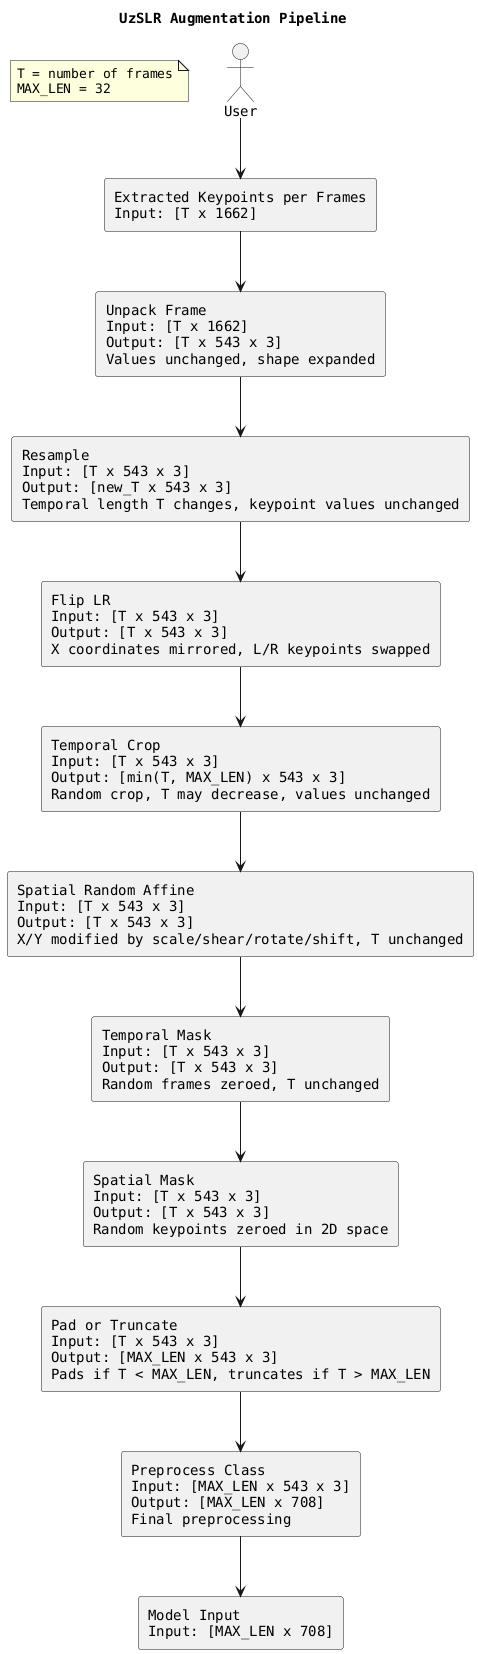

In [41]:
Image(filename='../../docs/images/augment_v1_data_flow.png', width=300) 

<details>

<summary><i>To see, augmentation PlantUML code, click here.</i></summary>

## PlantUML code:

```code
@startuml
title UzSLR Augmentation Pipeline

skinparam defaultFontName Courier

note "T = number of frames\nMAX_LEN = 32" as N1

' Input
actor User
rectangle "Extracted Keypoints per Frames\nInput: [T x 1662]" as raw

' Unpack
rectangle "Unpack Frame\nInput: [T x 1662]\nOutput: [T x 543 x 3]\nValues unchanged, shape expanded" as unpack

' Resample
rectangle "Resample\nInput: [T x 543 x 3]\nOutput: [new_T x 543 x 3]\nTemporal length T changes, keypoint values unchanged" as resample

' Flip LR
rectangle "Flip LR\nInput: [T x 543 x 3]\nOutput: [T x 543 x 3]\nX coordinates mirrored, L/R keypoints swapped" as flip

' Temporal Crop
rectangle "Temporal Crop\nInput: [T x 543 x 3]\nOutput: [min(T, MAX_LEN) x 543 x 3]\nRandom crop, T may decrease, values unchanged" as t_crop

' Spatial Random Affine
rectangle "Spatial Random Affine\nInput: [T x 543 x 3]\nOutput: [T x 543 x 3]\nX/Y modified by scale/shear/rotate/shift, T unchanged" as s_affine

' Temporal Mask
rectangle "Temporal Mask\nInput: [T x 543 x 3]\nOutput: [T x 543 x 3]\nRandom frames zeroed, T unchanged" as t_mask

' Spatial Mask
rectangle "Spatial Mask\nInput: [T x 543 x 3]\nOutput: [T x 543 x 3]\nRandom keypoints zeroed in 2D space" as s_mask

' Pad or Truncate
rectangle "Pad or Truncate\nInput: [T x 543 x 3]\nOutput: [MAX_LEN x 543 x 3]\nPads if T < MAX_LEN, truncates if T > MAX_LEN" as pad

' Preprocess
rectangle "Preprocess Class\nInput: [MAX_LEN x 543 x 3]\nOutput: [MAX_LEN x 708]\nFinal preprocessing" as preprocess

' Model
rectangle "Model Input\nInput: [MAX_LEN x 708]" as model

' Flow arrows
User --> raw
raw --> unpack
unpack --> resample
resample --> flip
flip --> t_crop
t_crop --> s_affine
s_affine --> t_mask
t_mask --> s_mask
s_mask --> pad
pad --> preprocess
preprocess --> model

@enduml


```

</details>

| Step                               | Input Shape           | Output Shape                  | Description                               |
| ---------------------------------- | --------------------- | ----------------------------- | --------------------------------------------------------- |
| Extracted Keypoints per Frames | `[T x 1662]`          | `[T x 1662]`                  | Raw keypoints extracted per frame                        |
| Unpack Frame                   | `[T x 1662]`          | `[T x 543 x 3]`               | Values unchanged, shape expanded to separate coordinates |
| Resample                       | `[T x 543 x 3]`       | `[new_T x 543 x 3]`           | Temporal length changes, keypoint values unchanged       |
| Flip LR                        | `[T x 543 x 3]`       | `[T x 543 x 3]`               | X coordinates mirrored, left/right keypoints swapped     |
| Temporal Crop                  | `[T x 543 x 3]`       | `[min(T, MAX_LEN) x 543 x 3]` | Random crop along time, T may decrease                   |
| Spatial Random Affine          | `[T x 543 x 3]`       | `[T x 543 x 3]`               | Scale, shear, rotate, shift applied to X/Y, T unchanged  |
| Temporal Mask                  | `[T x 543 x 3]`       | `[T x 543 x 3]`               | Random frames zeroed                                     |
| Spatial Mask                   | `[T x 543 x 3]`       | `[T x 543 x 3]`               | Random keypoints zeroed in 2D space                      |
| Pad or Truncate                | `[T x 543 x 3]`       | `[MAX_LEN x 543 x 3]`         | Pads if T < MAX_LEN, truncates if T > MAX_LEN            |
| Preprocess Class               | `[MAX_LEN x 543 x 3]` | `[MAX_LEN x 708]`             | Final preprocessing, normalization, feature selection and engineering             |
| Model Input                    | `[MAX_LEN x 708]`     | `...`             | Input ready for model                                    |


## 3.4 dataset and dataloader

In [42]:
SIGN2IDX

{'assalomu_alaykum': 0,
 'bahor': 1,
 'birga': 2,
 "bo'sh": 3,
 'bosh_kiyim': 4,
 'boshlanishi': 5,
 'bozor': 6,
 'eshik': 7,
 'futbol': 8,
 'iltimos': 9,
 'internet': 10,
 'javob': 11,
 'jismoniy_tarbiya': 12,
 'karam': 13,
 'kartoshka': 14,
 'kichik': 15,
 'kitob': 16,
 "ko'prik": 17,
 'likopcha': 18,
 'maktab': 19,
 'mehmonxona': 20,
 'mehribon': 21,
 'metro': 22,
 'musiqa': 23,
 "o'simlik_yog'i": 24,
 "o'ynash": 25,
 'ochish': 26,
 'ot': 27,
 'ovqat_tayyorlash': 28,
 'oxiri': 29,
 'poezd': 30,
 'pomidor': 31,
 'qidirish': 32,
 'qish': 33,
 "qo'ziqorin": 34,
 'qor': 35,
 "qorong'i": 36,
 'quyon': 37,
 'restoran': 38,
 "sariyog'": 39,
 'shokolad': 40,
 'sovun': 41,
 'stakan': 42,
 'televizor': 43,
 'tosh': 44,
 'toza': 45,
 'turish': 46,
 "yomg'ir": 47,
 'yopish': 48,
 'yordam_berish': 49}

---

<pre>
frame-XX.npy        -> (1662,)
32 stacked frames   -> (32, 1662)
Preprocess          -> returns (32, 708)
Dataset[i]          -> one repetition (x:sequence, y:label); x:(32,708) y:class index (0-49)
DataLoader batch    -> (B, 32, 708)
Model               -> predicts 1 sign label, based on (32, 708) input
</pre>

---

**For training split only:**
-
#### **Dataset Class:**
- 50 signs
- 40–41 repetitions per sign
    
Total samples ≈ 2000 repetitions  
Each `__getitem__` should return:  
**x**: Tensor of shape `(32, 708)`  
**y**: class index `(0–49) int`    
<pre>
    Dataset length ≈ 2000
    Dataset[i] = (sequence, label)
 </pre>

#### **DataLoader Class:**
- for instance **IF** `batch_size = 16`  
- DataLoader stacks each sample(repetition) along a new batch dimension
<pre>
(batch_size, T, features)
= (16, 32, 708)
</pre>
- This is what the model will be feed with `(B, 32, 708)`.
```python
def forward(self, x):
    # x.shape == (B, T, F)
    # (batch, time, features)
```

#### **Overall picture:**
<pre>
Filesystem
 └── rep-XX/
     └── 32 frames (.npy)

Dataset[i]
 ├── loads 32 frames
 ├── x: (32, 708)
 └── y: label 0-49 (int)

DataLoader
 ├── batch of repetitions
 └── x: (B, 32, 708)

Model
 └── predicts ONE label per repetition, based on (32, 708) input
</pre>

In [43]:
class SignDataset(Dataset):
    def __init__(self, root, split="train", augment=False, max_len=MAX_LEN):
        self.samples = []
        self.augment = augment
        self.max_len = max_len
        self.preprocess = Preprocess(max_len=max_len)

        split_path = os.path.join(root, split)
        for entry in os.scandir(split_path):
            if not entry.is_dir() or entry.name.startswith("."):
                continue
            sign = entry.name
            if sign not in SIGN2IDX:
                continue
            label = SIGN2IDX[sign]

            for rep_entry in os.scandir(entry.path):
                if not rep_entry.is_dir() or rep_entry.name.startswith("."):
                    continue
                frames = sorted(glob.glob(os.path.join(rep_entry.path, "*.npy")))
                if len(frames) == 0:
                    continue
                self.samples.append((frames, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx] # (T, 1662)

        # Load all frames at once
        frames_np = np.stack([np.load(p) for p in frame_paths])  # (T, 1662)
        
        # Vectorized unpacking
        frames_np = frames_np.astype(np.float32)
        x = torch.from_numpy(frames_np).to(torch.float32)  # (T, 1662) torch.float32
        
        # Unpack in batch
        face = x[:, 0:468 * 3].reshape(-1, 468, 3)
        pose = x[:, 468*3 : 468*3 + 33*4].reshape(-1, 33, 4)[:, :, :3] # drop visibility
        rh = x[:, 468*3 + 33*4 : 468*3+ 33*4 + 21*3].reshape(-1, 21, 3)
        lh = x[:, 468*3 + 33*4 + 21*3 :].reshape(-1, 21, 3)
        x = torch.cat([face, pose, rh, lh], dim=1)  # (T, 543, 3)
        
        # it expects (T, 543, 3)
        if self.augment: 
            x = augment_fn(x) # may increase or decrease number of frames (T)

        x = self.pad_or_truncate(x) # helps to keep number of frames constant at 32 for each repetitions

        x = self.preprocess(x)  # normalizations, feature selection and engineering, dimensionality reduction
        y = torch.tensor(label, dtype=torch.long)  # labels, folder name is the label
        return x, y

    def pad_or_truncate(self, x):
        """
        Ensures temporal length is MAX_LEN: pad if shorter, truncate if longer
        """
        if x.shape[0] < self.max_len:
            pad = torch.zeros(
                (self.max_len - x.shape[0], x.shape[1], x.shape[2]), 
                dtype=x.dtype, 
                device=x.device)
            x = torch.cat([x, pad], dim=0)
        else:
            x = x[:self.max_len]
        return x

### 3.4.1 testing dataset and dataloader with fake data

In [44]:
!pwd

/Users/macbookair/ISLR/preprocessing/notebooks


In [45]:
FAKE_DATA_ROOT = "./fake_data"
FAKE_SIGNS = ['assalomu_alaykum', 'bahor', 'birga', "bo'sh", 'bosh_kiyim']  # 5 fake signs for testing
FAKE_REPS = 5  # number of repetitions per sign, and it is treated as a single training sample
FAKE_FRAMES_PER_REP = 32
FAKE_NUM_FEATURES = 1662

# create folders and fake .npy files
for split in SPLITS:
    for sign in FAKE_SIGNS:
        for rep in range(FAKE_REPS):
            folder = os.path.join(FAKE_DATA_ROOT, split, sign, f"rep-{rep}")
            os.makedirs(folder, exist_ok=True)
            for f in range(FAKE_FRAMES_PER_REP):
                frame_path = os.path.join(folder, f"frame-{f:02d}.npy")
                # fake data random numbers
                np.save(frame_path, np.random.randn(FAKE_NUM_FEATURES).astype(np.float64))

print("Fake dataset created!")

Fake dataset created!


In [46]:
FAKE_SIGN2IDX = {s: i for i, s in enumerate(FAKE_SIGNS)}

In [47]:
FAKE_SIGN2IDX

{'assalomu_alaykum': 0, 'bahor': 1, 'birga': 2, "bo'sh": 3, 'bosh_kiyim': 4}

In [48]:
# Dataset
train_dataset = SignDataset(FAKE_DATA_ROOT, split="train", augment=True) # augmentation is applied only for training set
val_dataset   = SignDataset(FAKE_DATA_ROOT, split="validation", augment=False)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # to avoid order bias, shuffle is enabled for training set
val_loader   = DataLoader(val_dataset, batch_size=2) # to ensure consistent comparison shuffle is disabled for validation set

In [49]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print("x shape:", x.shape)  # expected (B, 32, 708)
    print("y shape:", y.shape)  # expected (B,)
    print("y:", y, "\n")
    continue

Batch 0
x shape: torch.Size([16, 32, 708])
y shape: torch.Size([16])
y: tensor([3, 3, 4, 1, 1, 0, 3, 0, 4, 2, 0, 0, 4, 2, 3, 3]) 

Batch 1
x shape: torch.Size([9, 32, 708])
y shape: torch.Size([9])
y: tensor([1, 4, 0, 4, 2, 2, 1, 2, 1]) 



In [50]:
# checking
all_labels = []
for _, y in train_loader:
    all_labels.extend(y.tolist())

print(sorted(set(all_labels))) # confirming that all signs are in the dataset

[0, 1, 2, 3, 4]


### 3.4.2 visualization of preprocessing and augmentation pipeline

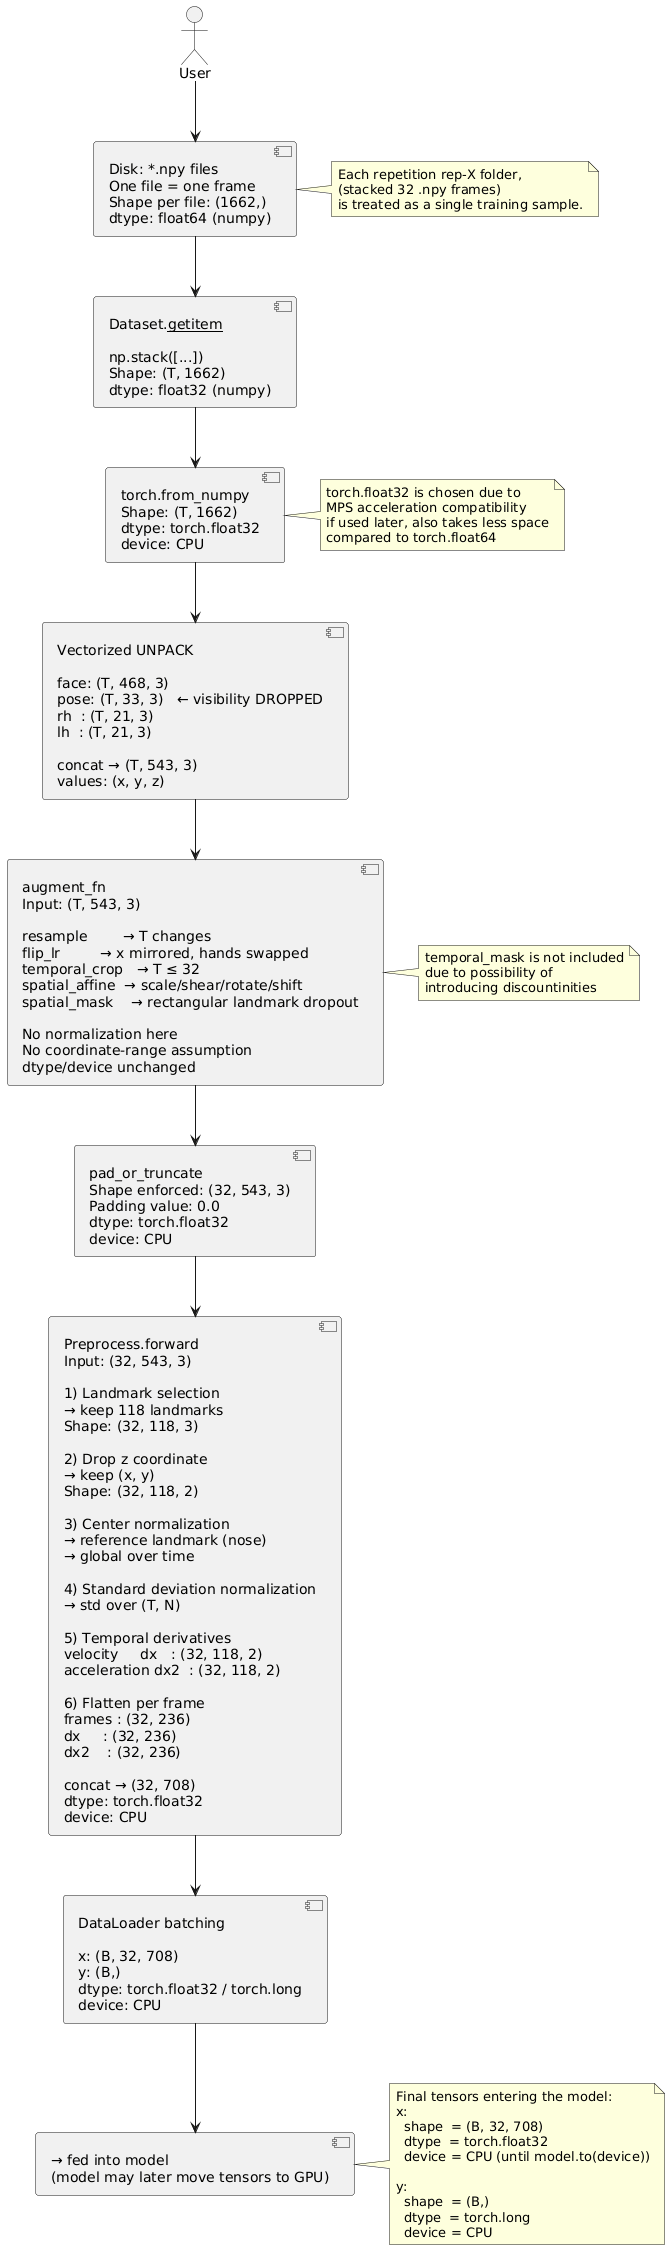

In [51]:
Image(filename='../../docs/images/data_preprocess_augment_v1.png', width=500) 

<details>
<summary><i>To see PlantUML code, click here.</i></summary>

## PlantUML code:

```code
@startuml
top to bottom direction

actor User

component "Disk: *.npy files\nOne file = one frame\nShape per file: (1662,)\ndtype: float64 (numpy)" as Disk

note right
  Each repetition rep-X folder,
  (stacked 32 .npy frames)
  is treated as a single training sample.
end note

component "Dataset.__getitem__\n\nnp.stack([...])\nShape: (T, 1662)\ndtype: float32 (numpy)" as GetItem

component "torch.from_numpy\nShape: (T, 1662)\ndtype: torch.float32\ndevice: CPU" as FromNumpy

note right
torch.float32 is chosen due to 
MPS acceleration compatibility
if used later, also takes less space
compared to torch.float64
end note

component "Vectorized UNPACK\n\nface: (T, 468, 3)\npose: (T, 33, 3)   ← visibility DROPPED\nrh  : (T, 21, 3)\nlh  : (T, 21, 3)\n\nconcat → (T, 543, 3)\nvalues: (x, y, z)" as Unpack

component "augment_fn\nInput: (T, 543, 3)\n\nresample        → T changes\nflip_lr         → x mirrored, hands swapped\ntemporal_crop   → T ≤ 32\nspatial_affine  → scale/shear/rotate/shift\nspatial_mask    → rectangular landmark dropout\n\nNo normalization here\nNo coordinate-range assumption\ndtype/device unchanged" as Augment

note right
temporal_mask is not included
due to possibility of 
introducing discountinities
end note

component "pad_or_truncate\nShape enforced: (32, 543, 3)\nPadding value: 0.0\ndtype: torch.float32\ndevice: CPU" as Pad

component "Preprocess.forward\nInput: (32, 543, 3)\n\n1) Landmark selection\n→ keep 118 landmarks\nShape: (32, 118, 3)\n\n2) Drop z coordinate\n→ keep (x, y)\nShape: (32, 118, 2)\n\n3) Center normalization\n→ reference landmark (nose)\n→ global over time\n\n4) Standard deviation normalization\n→ std over (T, N)\n\n5) Temporal derivatives\nvelocity     dx   : (32, 118, 2)\nacceleration dx2  : (32, 118, 2)\n\n6) Flatten per frame\nframes : (32, 236)\ndx     : (32, 236)\ndx2    : (32, 236)\n\nconcat → (32, 708)\ndtype: torch.float32\ndevice: CPU" as Preprocess

component "DataLoader batching\n\nx: (B, 32, 708)\ny: (B,)\ndtype: torch.float32 / torch.long\ndevice: CPU" as DataLoader

component "→ fed into model\n(model may later move tensors to GPU)" as Model

note right
Final tensors entering the model:
x:
  shape  = (B, 32, 708)
  dtype  = torch.float32
  device = CPU (until model.to(device))

y:
  shape  = (B,)
  dtype  = torch.long
  device = CPU
end note

User --> Disk
Disk --> GetItem
GetItem --> FromNumpy
FromNumpy --> Unpack
Unpack --> Augment
Augment --> Pad
Pad --> Preprocess
Preprocess --> DataLoader
DataLoader --> Model

@enduml

```
</details>

#### **Data Pipeline Flow with Shapes, Dtypes, and Devices**

| Step                          | Input Shape                          | Output Shape                          | Description                                                                 | Dtype                  | Device |
|-------------------------------|--------------------------------------|---------------------------------------|-----------------------------------------------------------------------------|------------------------|--------|
| Disk Storage                  | -                                    | `(1662,)` per file                   | One `*.npy` file = one frame<br>Each sample: stack of 32 frames from rep-X folder | `float64` (numpy)     | `Disk` |
| `Dataset.__getitem__`           | 32 × `(1662,)`                       | `(T, 1662)`                          | Stack 32 loaded `.npy` frames                                               | `float32` (numpy)     | `CPU`  |
| `torch.from_numpy`              | `(T, 1662)`                          | `(T, 1662)`                          | Convert numpy array to torch tensor<br>(T is usually 32 at this point)      | `torch.float32`       | `CPU`  |
| Vectorized UNPACK             | `(T, 1662)`                          | `(T, 543, 3)`                        | Unpack into:<br>- face: `(T, 468, 3)`<br>- pose: `(T, 33, 3)` (visibility dropped)<br>- right hand: `(T, 21, 3)`<br>- left hand: `(T, 21, 3)`<br>Concat -> `(T, 543, 3)` (x, y, z values) | `torch.float32`       | `CPU`  |
| augment_fn                    | `(T, 543, 3)`                        | `(T', 543, 3)` (T' varies, ≤32)       | Applies:<br>- resample (T changes)<br>- flip_lr (mirror x, swap hands)<br>- temporal_crop<br>- spatial_affine (scale/shear/rotate/shift)<br>- spatial_mask (rectangular dropout)<br>No normalization, no temporal mask | `torch.float32`       | `CPU`  |
| pad_or_truncate               | `(T', 543, 3)`                       | `(32, 543, 3)`                       | Enforce fixed length 32<br>Pad with 0.0 or truncate                         | `torch.float32`       | `CPU`  |
| `Preprocess.forward`            | `(32, 543, 3)`                       | `(32, 708)`                          | 1. Landmark selection -> 118 landmarks<br>2. Drop z -> `(32, 118, 2)`<br>3. Center normalization (nose reference, global over time)<br>4. Std normalization (over T×N)<br>5. Temporal derivatives: velocity & acceleration -> `(32, 118, 2)` each<br>6. Flatten per frame and concat -> `(32, 708)` | `torch.float32`       | `CPU`  |
| `DataLoader` batching           | Multiple × `(32, 708)` + labels      | x: `(B, 32, 708)`<br>y: `(B,)`       | Batch <br>x: features<br>y: class labels `int (0-49)`                          | `torch.float32` (x)<br>`torch.long` (y) | `CPU`  |
| Model input                   | x: `(B, 32, 708)`<br>y: `(B,)`       | -                                    | Tensors fed into model<br>(model may later move to GPU/MPS using `.to(device)`) | `torch.float32` (x)<br>`torch.long` (y) | `CPU` -> (GPU/MPS possible) |

**Notes:**
- `torch.float32` is used throughout for compatibility with MPS acceleration and reduced memory usage compared to `float64`.
- Augmentations do not include temporal masking to avoid introducing discontinuities.
- All normalization (centering and std) happens inside `Preprocess.forward` and augmentations operate on raw mediapipe coordinates.
- Final input to the model: `x` of shape `(B, 32, 708)` (`torch.float32`) and `y` of shape `(B,)` (`torch.long`).